<a href="https://colab.research.google.com/github/sangeetsaurabh/tweet_sentiment_extraction/blob/master/twitter_text_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torchtext==0.6.0

In [2]:
!sudo apt-get install libhunspell-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libhunspell-dev is already the newest version (1.6.2-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [3]:
!pip install spacy_hunspell

In [4]:
!pip3 install Cython

In [5]:
import pandas as pd
import re
from collections import Collection

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import spacy
import numpy as np

import random
import math
import time
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

##### Mount the Google drive for input/output

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_folder = "/content/drive/My Drive/tweet-sentiment-extraction/data"
tmp_folder = '/tmp'

In [8]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

train_data = pd.read_csv(data_folder+ "/train.csv")
test_data = pd.read_csv(data_folder+ "/test.csv")

print(train_data.shape)
print(test_data.shape)

(27481, 4)
(3534, 3)


In [9]:
### Removing rows with null value
train_data = train_data[train_data.text == train_data.text]
test_data = test_data[test_data.text == test_data.text]

In [10]:
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [11]:
train_data.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [12]:
### Remove spaces before and after sentecnces
train_data["text_len"] = train_data["text"].str.strip()
train_data["sel_text_len"] = train_data["selected_text"].str.strip()

#### Calculate the number of words
train_data["text_len"] = train_data["text"].str.split()
train_data["sel_text_len"] = train_data["selected_text"].str.split()

train_data["text_len"] = train_data["text_len"].str.len()
train_data["sel_text_len"] = train_data["sel_text_len"].str.len()

In [13]:
train_data.head()

,textID,text,selected_text,sentiment,text_len,sel_text_len
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,3
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,14,3


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f81f50bde80>,
      dtype=object)

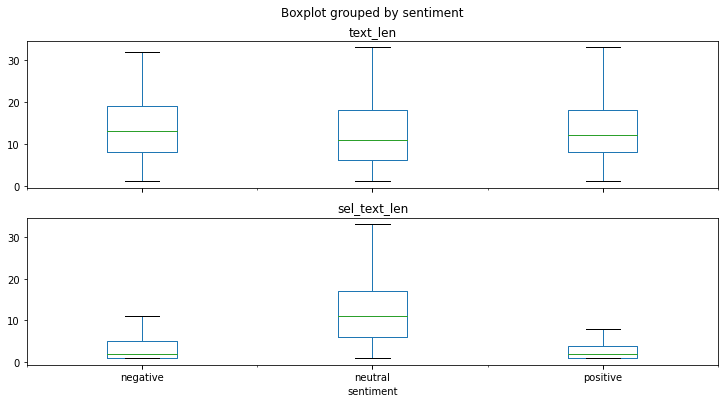

In [14]:
train_data[["sentiment","text_len","sel_text_len"]].boxplot(by="sentiment",column=["text_len","sel_text_len"], showfliers=False,grid=False,layout=(2, 1),figsize=(12,6))


In [15]:
train_data[["text_len","sel_text_len"]].describe()

,text_len,sel_text_len
count,27480.000000,27480.000000
mean,12.902875,7.102511
std,6.925938,6.891179
min,1.000000,1.000000
25%,7.000000,1.000000
50%,12.000000,4.000000
75%,18.000000,11.000000
max,33.000000,33.000000


#### Save the data to load into Torch dataset

In [16]:
train_data["text"].to_csv(tmp_folder + "/train_data.text",index=False,header=False)
train_data["selected_text"].to_csv(tmp_folder + "/train_data.stext",index=False,header=False)

#### Load the Torch dataset

In [17]:
#### Preprocessing of data
from typing import Collection
import html
BOS,EOS,FLD,UNK,PAD = 'xxbos','xxeos','xxfld','xxunk','xxpad'
TK_MAJ,TK_UP,TK_REP,TK_WREP = 'xxmaj','xxup','xxrep','xxwrep'

def spec_add_spaces(t:str) -> str:
    "Add spaces around / and # in `t`. \n"
    #print(t)
    return re.sub(r'([/#\n/.])', r' \1 ', t)


def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(' {2,}', ' ', t)


def replace_rep(t:str) -> str:
    "Replace repetitions at the character level in `t`."
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)

def replace_wrep(t:str) -> str:
    "Replace word repetitions in `t`."
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def fix_html(x:str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace(' @,@ ',',').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def replace_all_caps(x:Collection[str]) -> Collection[str]:
    "Replace tokens in ALL CAPS in `x` by their lower version and add `TK_UP` before."
    res = []
    for t in x:
        if t.isupper() and len(t) > 1: res.append(TK_UP); res.append(t.lower())
        else: res.append(t)
    return res

def deal_caps(x:Collection[str]) -> Collection[str]:
    "Replace all Capitalized tokens in `x` by their lower version and add `TK_MAJ` before."
    res = []
    for t in x:
        if t == '': continue
        if t[0].isupper() and len(t) > 1 and t[1:].islower(): res.append(TK_MAJ)
        res.append(t.lower())
    return res

text_pre_rules = [fix_html, replace_rep, replace_wrep, spec_add_spaces, rm_useless_spaces]
text_post_rules = [replace_all_caps, deal_caps]

In [18]:
def sequential_transforms(transforms=[]):
    def _forward(txt_input):
        #print(txt_input)
        for transform in transforms:
            #print(transform)
            txt_input = transform(txt_input)
        return txt_input
    return _forward

In [19]:
text_preprocess = sequential_transforms(text_pre_rules)

text_post_preprocess = sequential_transforms(text_post_rules)

In [20]:
text_preprocess("Sons of ****, why couldn`t they put them on the releases we already bought")

'Sons of xxrep 4 * , why couldn`t they put them on the releases we already bought'

In [21]:
spacy_en = spacy.load('en')

In [22]:
def tokenize_src(text):
    """
    Tokenizes text from a string into a list of strings (tokens) and reverses it
    """
    #return [tok.text for tok in spacy_en.tokenizer(text)][::-1]
    text = text_preprocess(text)
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_trg(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    text = text_preprocess(text)
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [23]:
src_sentences = Field(tokenize = tokenize_src, 
              init_token = '<sos>', 
              eos_token = '<eos>', 
              lower = False,
              preprocessing = text_post_preprocess)
              #postprocessing = text_post_preprocess)

trg_sentences = Field(tokenize = tokenize_trg, 
              init_token = '<sos>', 
              eos_token = '<eos>', 
              lower = False,
              preprocessing = text_post_preprocess)
              #postprocessing = text_post_preprocess)

Load the Train *Datasets* to understand words and characters in sentences

In [24]:
(train_dataset) = TranslationDataset.splits(exts = ('.text', '.stext'), path=tmp_folder,
                                                    fields = (src_sentences, trg_sentences),train='train_data',validation=None,test=None)

In [25]:
train_dataset = train_dataset[0]

In [26]:
vars(train_dataset.examples[1])

{'src': ['xxmaj',
  'sooo',
  'xxup',
  'sad',
  'i',
  'will',
  'miss',
  'you',
  'here',
  'in',
  'xxmaj',
  'san',
  'xxmaj',
  'diego',
  '!',
  '!',
  '!'],
 'trg': ['xxmaj', 'sooo', 'xxup', 'sad']}

In [27]:
print(vars(train_dataset.examples[20]))

{'src': ['"', 'oh', 'xxmaj', 'marly', ',', 'xxmaj', 'i`m', 'so', 'sorry', '!', '!', 'i', 'hope', 'you', 'find', 'her', 'soon', '!', '!', '<3', '<3', '"'], 'trg': ['"', 'oh', 'xxmaj', 'marly', ',', 'xxmaj', 'i`m', 'so', 'sorry', '!', '!', 'i', 'hope', 'you', 'find', 'her', 'soon', '!', '!', '<3', '<3', '"']}


In [28]:
print(f"Number of training examples: {len(train_dataset.examples)}")
#print(f"Number of validation examples: {len(valid_data.examples)}")

Number of training examples: 27480


Build the vocab

In [29]:
src_sentences.build_vocab(train_dataset, min_freq = 1)
trg_sentences.build_vocab(train_dataset, min_freq = 1)
print(f"Unique tokens in source (Text) vocabulary: {len(src_sentences.vocab)}")
print(f"Unique tokens in target (SSelected Text) vocabulary: {len(trg_sentences.vocab)}")

Unique tokens in source (Text) vocabulary: 26698
Unique tokens in target (SSelected Text) vocabulary: 17782


In [30]:
src_sentences.vocab.itos[0:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'xxmaj', '.', 'i', '!', '"', 'to']

In [31]:
src_sentences.vocab.stoi['xxup']

12

##### Words that exist in selected text, but they don't existed in original text

In [32]:
len(set(trg_sentences.vocab.itos)  - set(src_sentences.vocab.itos))

178

In [33]:
### List of words that are different
set(trg_sentences.vocab.itos)  - set(src_sentences.vocab.itos)

{'")',
 '-a',
 '-cryy',
 '-e-',
 '-goodness',
 '-hugs',
 '-sorry',
 '-unfortunately',
 '10jsep',
 '1doe',
 '21u',
 '2n',
 '664',
 '6rww',
 'aam',
 'addicti',
 'af',
 'aga',
 'agai',
 'als',
 'amazi',
 'americ',
 'amie',
 'appreciat',
 'aroun',
 'artis',
 'ats',
 'awes',
 'aweso',
 'awesome!wa',
 'bastard',
 'behin',
 'bett',
 'bles',
 'br',
 'bumme',
 'candic',
 'canï',
 'catche',
 'cet0',
 'cheshire_cat',
 'circl',
 'cl',
 'clea',
 'clueles',
 'compan',
 'condolence',
 'craz',
 'credi',
 'crosse',
 'dar',
 'day*l',
 'delicio',
 'depresse',
 'depressi',
 'deserv',
 'differe',
 'dxd',
 'eels',
 'eithe',
 'elet',
 'embarrass',
 'endearing-',
 'enj',
 'enjoye',
 'enjoyyitverymu',
 'ev',
 'excit',
 'faile',
 'followe',
 'foreve',
 'forrea',
 'forwar',
 'frustrade',
 'gla',
 'goodb',
 'goodnit',
 'gorgeou',
 'handsom',
 'happ',
 'harde',
 'ies',
 'ignor',
 'ignorin',
 'ile',
 'inpu',
 'interventio',
 'iphon',
 'javaon',
 'jibber',
 'jokin',
 'kath',
 'kew',
 'kis',
 'kittie',
 'ks',
 'kudo'

Break the vocab count by alpha, numeric, alphanumeric

In [35]:
alpha_vocab = []
numeric_vocab = []
alnum_vocab = []
other_vocab = []
for the_word in src_sentences.vocab.itos:
  if the_word.isalpha() == True:
    alpha_vocab.append(the_word)
  elif the_word.isnumeric() == True:
    numeric_vocab.append(the_word)
  elif the_word.isalnum() == True:
    alnum_vocab.append(the_word)
  else:
    other_vocab.append(the_word)

print (f'Number of Alpha only words: {len(alpha_vocab)}')
print (f'Number of Numeric only words: {len(numeric_vocab)}')
print (f'Number of Alpha Numeric words: {len(alnum_vocab)}')
print (f'Number of words with special characters: {len(other_vocab)}')

Number of Alpha only words: 22978
Number of Numeric only words: 343
Number of Alpha Numeric words: 1369
Number of words with special characters: 2008


#### List out all the characters (alphanumeric, punctuation, special characters etc.) that exist in the files

In [36]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('/tmp/*text'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        #if unicodedata.category(c) != 'Mn'
        #and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
    #return lines

for filename in findFiles('/tmp/*text'):
    category = os.path.splitext(os.path.basename(filename))[1]
    print(category)
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/tmp/train_data.text', '/tmp/train_data.stext']
Ślusàrski
.text
.stext


In [37]:
print(len(category_lines['.text']))
print(len(category_lines['.stext']))

27480
27480


In [38]:
text_characters = []
for text_line in category_lines['.text']:
  text_line = text_line.strip('"')
  if len(text_characters) == 0:
    text_characters = list(text_line.replace(" ", ""))
  else:
    text_characters += list(text_line.replace(" ", ""))

stext_characters = []
for text_line in category_lines['.stext']:
  text_line = text_line.strip('"')
  if len(text_characters) == 0:
    stext_characters = list(text_line.replace(" ", ""))
  else:
    stext_characters += list(text_line.replace(" ", ""))


In [39]:
print (f'Number of special characters in Original tweet: {len(set(text_characters))}')
print (f'Number of special characters in Selected Text: {len(set(stext_characters))}')

Number of special characters in Original tweet: 100
Number of special characters in Selected Text: 96


In [40]:
set(text_characters) - set(stext_characters)

{'\t', '\xa0', '´', '̂'}

Above special characters don't exist in selected text

In [41]:
from collections import Counter
text_characters_count = Counter(text_characters)
stext_characters_count = Counter(stext_characters)

In [42]:
text_characters_count.most_common()

[('e', 143971),
 ('o', 123986),
 ('t', 123435),
 ('a', 106676),
 ('i', 90243),
 ('n', 89164),
 ('s', 78533),
 ('h', 68137),
 ('r', 66746),
 ('l', 57982),
 ('d', 48306),
 ('u', 43125),
 ('y', 42490),
 ('m', 42345),
 ('g', 37162),
 ('.', 35815),
 ('w', 34367),
 ('c', 30088),
 ('p', 24543),
 ('f', 24114),
 ('b', 21522),
 ('k', 19809),
 ('!', 15296),
 ('I', 14806),
 ('v', 13399),
 ('`', 11628),
 (',', 8495),
 ('T', 5545),
 ('*', 4953),
 ('S', 4818),
 ('A', 4673),
 ('/', 4515),
 ('?', 4266),
 ('M', 4183),
 ('H', 4170),
 ('O', 4168),
 ('j', 3522),
 ('E', 3253),
 ('L', 3224),
 ('W', 3115),
 ('N', 2959),
 ('x', 2880),
 ('D', 2872),
 ('B', 2685),
 ('-', 2655),
 ('G', 2654),
 (':', 2427),
 ('C', 2413),
 ('Y', 2247),
 ('R', 2025),
 ('P', 2005),
 ('F', 1819),
 ('z', 1798),
 ('2', 1755),
 ('0', 1671),
 ('1', 1584),
 ('_', 1576),
 ('U', 1352),
 ('3', 1328),
 ('J', 1301),
 ("'", 1288),
 ('4', 1100),
 ('K', 890),
 (')', 870),
 ('5', 829),
 ('&', 800),
 ('(', 761),
 ('V', 744),
 ('q', 733),
 ('6', 689)

In [43]:
stext_characters_count.most_common()

[('e', 80028),
 ('o', 68910),
 ('t', 66641),
 ('a', 58325),
 ('i', 49457),
 ('n', 49066),
 ('s', 44357),
 ('r', 37006),
 ('h', 36580),
 ('l', 32438),
 ('d', 27179),
 ('u', 23926),
 ('y', 23225),
 ('m', 22607),
 ('g', 20813),
 ('w', 18498),
 ('.', 18259),
 ('c', 16575),
 ('p', 13672),
 ('f', 13319),
 ('b', 11865),
 ('k', 11198),
 ('I', 8077),
 ('!', 8000),
 ('v', 7495),
 ('`', 6429),
 (',', 4517),
 ('T', 3111),
 ('*', 2906),
 ('S', 2648),
 ('A', 2529),
 ('H', 2500),
 ('?', 2385),
 ('O', 2382),
 ('M', 2120),
 ('E', 1891),
 ('j', 1867),
 ('L', 1787),
 ('W', 1678),
 ('N', 1666),
 ('G', 1556),
 ('D', 1523),
 ('x', 1515),
 ('/', 1425),
 ('B', 1423),
 ('C', 1360),
 ('Y', 1289),
 ('-', 1235),
 ('P', 1145),
 ('R', 1129),
 ('F', 992),
 ('z', 968),
 (':', 912),
 ('2', 839),
 ('0', 835),
 ('U', 788),
 ('1', 741),
 ("'", 668),
 ('3', 606),
 ('J', 599),
 ('_', 521),
 ('4', 454),
 ('K', 450),
 ('V', 418),
 ('&', 383),
 ('5', 377),
 (')', 371),
 ('q', 370),
 ('(', 336),
 ('#', 290),
 ('6', 262),
 ('8'

In [44]:
!pip install unidecode

     |████████████████████████████████| 245kB 3.4MB/s 


In [45]:
train_data[train_data.text.str.contains('`')].head()

,textID,text,selected_text,sentiment,text_len,sel_text_len
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,14,3
10,2339a9b08b,"as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff","as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff",neutral,23,23
16,3440297f8b,"S`ok, trying to plot alternatives as we speak *sigh*",*sigh*,negative,9,1
17,919fa93391,"i`ve been sick for the past few days and thus, my hair looks wierd. if i didnt have a hat on it would look... http://tinyurl.com/mnf4kw",sick,negative,25,1


In [46]:
train_data[train_data.text.str.contains("'")].head()

,textID,text,selected_text,sentiment,text_len,sel_text_len
45,a9d499e123,The girl in the hair salon asked me 'Shall I trim your eyebrows!' How old do I feel?,The girl in the hair salon asked me 'Shall I trim your eyebrows!' How old do I feel?,neutral,18,18
73,0c4aa867d0,"'you can ride one, you can catch one, but its not summer til you pop open one' ?","'you can ride one, you can catch one, but its not summer til you pop open one' ?",neutral,18,18
102,ebcdf07ac5,"1 week post my'horrible, traumatic jumping cholla accident.'-cholla`s next dirty trick:pieces are starting to emerge from my hand! Ouch!","horrible,",negative,19,1
104,6b018d3d2d,Awesome. I`m down in Ocean Beach (if you know where that is.) By the way. 'YourBiggestFan' I`m a re-al big fan of you-rs.,Awesome.,positive,23,1
268,84ca20505a,"I waited, listening to wind blowing through the tumbleweed? Are none of you old enough to know what to do when someone says 'Crackerack'?","I waited, listening to wind blowing through the tumbleweed? Are none of you old enough to know what to do when someone says 'Crackerack'?",neutral,24,24


### Analyze certain characters in the vocab

In [47]:
sub = "'"
src_list = []
trg_list = []

for s in src_sentences.vocab.itos:
  if sub.lower() in s.lower():
    src_list.append(s)

for s in trg_sentences.vocab.itos:
  if sub.lower() in s.lower():
    trg_list.append(s)

print(f"Src list length: {len(src_list)}")
print(f"Trg list length: {len(trg_list)}")

Src list length: 21
Trg list length: 10


In [ ]:
src_list

["'",
 "i'm",
 "'s",
 ":'(",
 ":')",
 "day?'*people",
 "my'horrible",
 "oceanup?'miley",
 "productive'-",
 "say'bitch",
 "tpg:'love",
 "unity'-mode",
 "us*'what"]

In [51]:
len(string.punctuation)

32

##### List out all the characters that are not alpha numeric, numeric or punctuation

In [53]:
for t in text_characters_count:
  if not ((t.isalpha()) or (t.isdigit()) or (t in string.punctuation)):
    print(repr(t), text_characters_count[t])
  

'̈' 225
'¿' 225
'½' 225
'̂' 5
'\xa0' 4
'\t' 1
'´' 1


###### Find out all the words with wrong spelling

In [55]:
import spacy
from spacy_hunspell import spaCyHunSpell

nlp = spacy.load('en_core_web_sm')
hunspell = spaCyHunSpell(nlp, 'linux')
nlp.add_pipe(hunspell)
doc = nlp('I can awesom123 cheezeburger.')
haz = doc[2]
print(haz.is_alpha)
print(haz._.hunspell_spell)  # False
haz._.hunspell_suggest  # ['ha', 'haze', 'hazy', 'has', 'hat', 'had', 'hag', 'ham', 'hap', 'hay', 'haw', 'ha z']

/usr/share/hunspell/en_US.dic /usr/share/hunspell/en_US.aff
False
False


['awesomeness']

In [56]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 3.5MB/s 


In [57]:
len(alpha_vocab)

22978

In [58]:
from spellchecker import SpellChecker
spell = SpellChecker()
misspelled = spell.unknown(alpha_vocab)

In [59]:
len(misspelled)

8268

In [60]:
train_data[train_data.text.str.contains('kalies')]

,textID,text,selected_text,sentiment,text_len,sel_text_len
13633,cfbdec51c4,time to go swimming in the freezing water at kalies. yeah!,yeah!,positive,11,1


Hmmm. Words may not be misspelled. They are just different meaning Nouns or slang.

In [62]:
train_data[train_data.text.str.contains('lutz')]

,textID,text,selected_text,sentiment,text_len,sel_text_len
9603,e587eeba94,hahaha tempting! but nvm la. i`m quite a klutz. i actually fare better with my hp cam LOL,i actually fare better,positive,18,4
16788,4817f7e516,fell down while holdin kales hand today...I hurt my foot & he bruised his forehead im such a klutz!,hurt my foot & he bruised his forehead im such a klutz!,negative,19,12


In [63]:
word_count = 0
for word in misspelled:
  print(word, spell.correction(word))
  print(spell.candidates(word))
  word_count += 1
  if word_count > 10:
    break


hehee here
{'heel', 'heem', 'hefce', 'henge', 'hee', 'hesse', 'heres', 'heuer', 'heed', 'huhne', 'renee', 'hepes', 'heber', 'sheree', 'leee', 'rhee', 'henze', 'helen', 'heh', 'hexes', 'hees', 'chee', 'thee', 'heyes', 'eee', 'pelee', 'hebe', 'ieee', 'ghee', 'here', 'heine', 'whee', 'heyer', 'hever', 'wheee', 'hebei', 'hewer', 'hemel', 'hedge', 'heave', 'shee', 'feher', 'hence', 'levee', 'herne', 'herve', 'heide', 'melee', 'heike', 'helene', 'hegel'}
jaron jason
{'aaron', 'juron', 'caron', 'aron', 'baron', 'jargon', 'jason'}
imma emma
{'pmma', 'irma', 'mima', 'umma', 'amma', 'itma', 'immac', 'imam', 'emma'}
dreambears dreamers
{'dreamers'}
workk work
{'work', 'works', 'worke'}
bmac mac
{'boac', 'bsac', 'bmc', 'brac', 'bac', 'bma', 'mac'}
dfizzy dizzy
{'fizzy', 'dizzy'}
charicee chalice
{'clarice', 'chargee', 'chalices', 'pharisee', 'chalice'}
magout mahout
{'mahout'}
godda goddam
{'goddam', 'gooda', 'gouda', 'goddy', 'rodda'}
everyonee everyone
{'everyone'}


So, there are 8268 misspelled words. But everything is not misspelled. We need to figure out which words to pick vs which words to leave.

##### Lemmetize the words experiment

In [64]:
import spacy
nlp = spacy.load('en')

separator = ', '
doc = nlp(separator.join(misspelled))

word_count = 0
for token in doc:
  if token.text != token.lemma_:
    print(token, token.lemma_)
    word_count += 1
    if word_count > 10:
      break


dreambears dreambear
guilted guilte
moives moive
jetsons jetson
lunes lune
wingnuts wingnut
starwarswithaddedpants starwarswithaddedpant
pedicures pedicure
restos resto
twiggies twiggie
honored honor


Lemmetize makes more sense. Will review it again once first model is ready.